# Machine Learning Engineer at the Department of New Products at Target

Today you are a Machine Learning Engineer at the Department of New Products at Target Cosmetics!
This work relies on processed data from Kaggle https://www.kaggle.com/mkechinov/ecommerce-events-history-in-cosmetics-shop

This work is motivated by the publication https://arxiv.org/pdf/2102.01625.pdf

Further details are at: https://arxiv.org/pdf/2010.02503.pdf

So far you have seen user-product interaction data that can lead to classification of a user-product relationship as ending in purchase or no-purchase, and for clustering (categorizing) user behaviors.

In this assignment, you have access to user-product level interactions without any insights into the user behaviors. Your goal is to classify if the "Products" will sell at least 5 pieces in a month (denoted by `Purchased? =`1) or not. The intention is to utilize as minimum product level as possible (price and product category only) at first and then designing a more complex system that ingests more product level information.

Labeled data is sparse, and the intention is to maximize Recall (so that no popular cosmetic is understocked). Digital overstocking is allowed since it will not cause disengagement in customers.

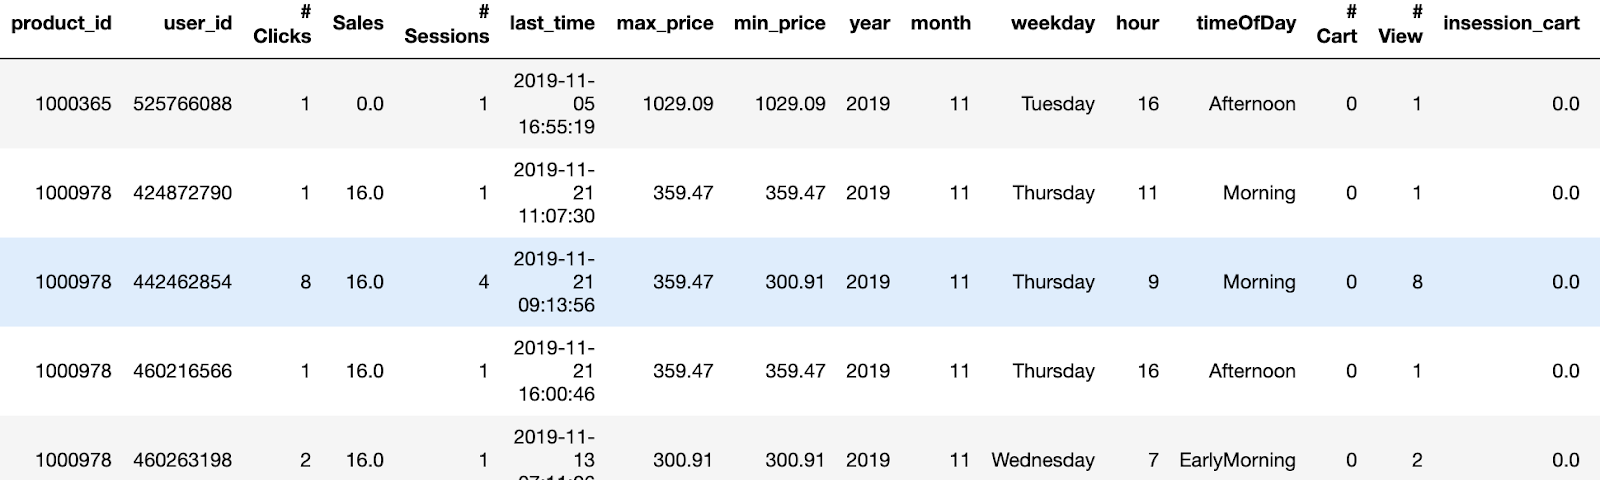

In [1]:
# The session-level data that is mined for this work is as follows:
from IPython.display import Image
Image(filename='data/image10.png')

This week you are helping plan the launch of new products! You start with minimal product information and then identify what other information is helpful for the task!

The minimal product level information available to you about the new products is their cost range and product category (cream, foundation, lipcolor, etc..).

You have to figure out how to mine the past cosmetic sales data from last month, utilize relevant features and to make estimations as to which products will sell more (`Purchased?` = 1)

## Task 0: Getting to know the Data!

In [2]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')

In [3]:
# Load the data from previous months (past)
Past = pd.read_csv("data/Past_month_products.csv")
print(Past.shape)
Past.head()

(5000, 37)


,product_id,user_id,NumOfEventsInJourney,NumSessions,interactionTime,maxPrice,minPrice,NumCart,NumView,NumRemove,...,Dec,Afternoon,Dawn,EarlyMorning,Evening,Morning,Night,Purchased?,Noon,Category
0,5866936,5.618978e+08,1.333333,1.333333,5550.000,15.84000,15.84000,0.00,1.333333,0.00,...,0.00,0.000,0.0,0.666667,0.333333,0.00,0.00,0,0.00,1.0
1,5647110,5.326529e+08,2.250000,1.500000,27556.500,5.80000,5.56500,1.25,0.250000,0.25,...,0.25,0.750,0.0,0.000000,0.250000,0.00,0.00,0,0.00,1.0
2,5790472,4.578109e+08,1.000000,1.000000,0.000,6.27250,6.27250,0.25,0.750000,0.00,...,0.00,0.000,0.0,0.000000,0.750000,0.25,0.00,0,0.00,1.0
3,5811598,4.612641e+08,1.500000,1.500000,131532.500,5.56000,5.56000,0.25,1.000000,0.25,...,0.25,0.000,0.0,0.000000,0.500000,0.00,0.25,0,0.25,1.0
4,5846363,5.157993e+08,1.875000,1.375000,11055.875,4.08625,4.08625,0.50,1.000000,0.25,...,0.25,0.375,0.0,0.125000,0.250000,0.25,0.00,1,0.00,1.0


In [4]:
# Next, load the data regarding products to be launched next month
Next = pd.read_csv("data/Next_month_products.csv")
print(Next.shape)
Next.head()

(30091, 5)


,product_id,maxPrice,minPrice,Purchased?,Category
0,5866502,7.616667,7.616667,0,1.0
1,5870408,6.270000,6.270000,0,3.0
2,5900580,10.008000,10.008000,0,1.0
3,5918778,5.980000,5.980000,0,2.5
4,5848772,26.830000,26.830000,0,1.0


Only the `product_id`, `maxPrice`, `minPrice`, and `Category` columns are common to both the training and test data

# Task 1: Exploratory Data Analysis (EDA) and Data Preparation
## EDA: Doing our your due diligence. Find the following:
1. Percentage of Purchased events in train data: 
2. Percentage of Purchased events in test data:
3. Are there any overlaps in product ID between train and test data?

In [5]:
y_train = Past["Purchased?"].values
print(f"Percentage of Purchased in Training data = {np.sum(y_train) / len(y_train) :.3f}")
y_test = Next['Purchased?'].values
print(f"Percentage of Purchased in Test data = {np.sum(y_test) / len(y_test) :.3f}")

# Verify that every product ID in the training data appears only once
print(f"Every product ID in the training data appears only once: {len(Past.product_id.unique()) == len(Past.product_id)}")
# Verify that every product ID in the test data appears only once
print(f"Every product ID in the test data appears only once: {len(Next.product_id.unique()) == len(Next.product_id)}")
# Determine whether any product IDs appear in both the training and test data
overlap = list(set(Next.product_id).intersection(set(Past.product_id)))
print(f"These product IDs are present in both the training and test data: {overlap}")

Percentage of Purchased in Training data = 0.344
Percentage of Purchased in Test data = 0.344
Every product ID in the training data appears only once: True
Every product ID in the test data appears only once: True
These product IDs are present in both the training and test data: []


## Next, create `X_train`, `y_train`, `X_test`, and `y_test`. Remember the following: 
1. The `Purchased?` column is the target
2. `X_train` and `X_test` should contain the same features
3. `product_id` should NOT be one of those features. Can you see why?

In [6]:
common_columns = Next.columns.to_numpy()
print(common_columns)
no_training = Past.shape[0]
no_test = Next.shape[0]

['product_id' 'maxPrice' 'minPrice' 'Purchased?' 'Category']


In [7]:
y_train = Past["Purchased?"].values
print(f"Percentage of Purchased in Training data = {np.sum(y_train) / len(y_train) :.3f}")
y_test = Next['Purchased?'].values
print(f"Percentage of Purchased in Test data = {np.sum(y_test) / len(y_test) :.3f}")

# Verify that every product ID in the training data appears only once
print(f"Every product ID in the training data appears only once: {len(Past.product_id.unique()) == len(Past.product_id)}")
# Verify that every product ID in the test data appears only once
print(f"Every product ID in the test data appears only once: {len(Next.product_id.unique()) == len(Next.product_id)}")
# Determine whether any product IDs appear in both the training and test data
overlap = list(set(Next.product_id).intersection(set(Past.product_id)))

print(f"These product IDs are present in both the training and test data: {overlap}")

Percentage of Purchased in Training data = 0.344
Percentage of Purchased in Test data = 0.344
Every product ID in the training data appears only once: True
Every product ID in the test data appears only once: True
These product IDs are present in both the training and test data: []


In [10]:
def return_train_test_data(df_old, df_new):
    common_columns = df_new.columns.drop(["product_id", "Purchased?"])
    X_train = df_old.loc[:, common_columns]
    y_train = df_old["Purchased?"].values[:, np.newaxis]
    X_test  = df_new.loc[:, common_columns]
    y_test  = df_new["Purchased?"].values[:, np.newaxis]

    return X_train, y_train, X_test, y_test
    
X_train, y_train, X_test, y_test = return_train_test_data(Past, Next)    
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.head(2))
print("\n")
print(X_test.head(2))

(5000, 3) (5000, 1) (30091, 3) (30091, 1)
   maxPrice  minPrice  Category
0     15.84    15.840       1.0
1      5.80     5.565       1.0


   maxPrice  minPrice  Category
0  7.616667  7.616667       1.0
1  6.270000  6.270000       3.0


# Task 2, Baselining: 
Build the best classifier using the Past month's data that will predict if the Next month's products will be Purchased or not?
Consider using AutoML to estimate the best classifier. Which features would you use from the training data?

In [ ]:
# Uncomment the following line if using Colab
# !pip install tpot

In [11]:
# TPOT for classification
from tpot import TPOTClassifier

# Instantiate and train a TPOT auto-ML classifier
# Set generations to 5, population_size to 40, and verbosity to 2 (so you can see each generation's performance)
tpot = TPOTClassifier(generations=5, population_size=40, verbosity=2, random_state=42)
tpot.fit(X_train, np.ravel(y_train))
# Evaluate the classifier on the test data
# By default, the scoring function is accuracy
print(tpot.score(X_test, np.ravel(y_test)))

tpot.export('tpot_products_pipeline.py')

Optimization Progress:   0%|          | 0/240 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8734

Generation 2 - Current best internal CV score: 0.8734

Generation 3 - Current best internal CV score: 0.8747999999999999

Generation 4 - Current best internal CV score: 0.8747999999999999

Generation 5 - Current best internal CV score: 0.8754000000000002

Best pipeline: BernoulliNB(XGBClassifier(input_matrix, learning_rate=0.5, max_depth=3, min_child_weight=17, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0), alpha=10.0, fit_prior=False)
0.8725864876541158


In [ ]:
#import multiprocessing  ## -> multithreaded option
#multiprocessing.set_start_method('forkserver', force=True)
#tpot = TPOTClassifier(generations=5, population_size=40, verbosity=2, n_jobs=4, random_state=230)
#tpot.fit(X_train, y_train)
#print(tpot.score(X_test, y_test))

#tpot.export('tpot_products_pipeline.py')

<!-- ## Modify the file `tpot_products_pipeline.py` to return the prediction labels for `X_test` and paste the function here or reload kernel to reload updated file -->

Use the appropriate lines of `tpot_products_pipeline.py` (and modify the relevant names) to write a function which returns the predicted labels generated by the best classifier which TPOT found 

In [13]:
from sklearn.pipeline import make_pipeline
from tpot.builtins import StackingEstimator
from xgboost import XGBClassifier
from sklearn.naive_bayes import BernoulliNB

def return_tpot_results(X_train, y_train, X_test):
    exported_pipeline = make_pipeline(
    StackingEstimator(estimator=XGBClassifier(learning_rate=0.5, max_depth=3, min_child_weight=17, 
                                              n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)),
                                              BernoulliNB(alpha=10.0, fit_prior=False)
    )
    
    exported_pipeline.fit(X_train, np.ravel(y_train))
    prediction = exported_pipeline.predict(X_test)

    return prediction

pred = return_tpot_results(X_train, y_train, X_test)

Evaluate the results of the best classifier which TPOT found

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score

# TPOT confusion matrix
cmtp = confusion_matrix(y_test, pred)
acc  = accuracy(y_test, pred)
rec  = recall(y_test, pred)
prec = precision(y_test, pred)
f1   = f1_score(y_test, pred)

print(f'Accuracy = {acc :.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}')
print('Confusion Matrix is:')
print(cmtp)

Accuracy = 0.873, Precision = 0.955, Recall = 0.661, F1-score = 0.781
Confusion Matrix is:
[[19410   322]
 [ 3512  6847]]


# Task 3, Semi-supervised learning: 
Apply label spreading on the data and run performance analysis by cross validation.

- Step 1: Combine `X_train` and `X_test`
- Step 2: Combine `y_train` and pad `y_test` with -1 labels
- Step 3: Run label spreading on complete data. Use knn spreading with `n_neighbors` varying as 2,3,5,7,9,11. What's the best neighborhood?


**Step 1.** Concatenate `X_train` and `X_test`

In [18]:
X = np.concatenate([X_train, X_test], axis=0)

print(X_train.shape)
print(X_test.shape)
print(X.shape)
print(y_train.shape)

(5000, 3)
(30091, 3)
(35091, 3)
(5000, 1)


Create an array shaped like a column of `X_test`, with each value equal to -1. Make sure the array is a column vector

**Step 2.** Concatenate `y_train` and `y_test`

In [24]:
y_hat = np.full(X_test.shape[0], -1)[:, np.newaxis]
y_hat

array([[-1],
       [-1],
       [-1],
       ...,
       [-1],
       [-1],
       [-1]])

Concatenate `y_train` and `y_hat`

In [25]:
y = np.concatenate([y_train, y_hat])
y

array([[ 0],
       [ 0],
       [ 0],
       ...,
       [-1],
       [-1],
       [-1]])

**Step 3.** Run label spreading

Instantiate and fit LabelSpreading to do a basic hyper-parameter tuning to find the best `n_neighbors`. Use a KNN kernel and set `alpha` to 0.01.

In [26]:
from sklearn.semi_supervised import LabelSpreading

In [31]:
from sklearn.semi_supervised import LabelSpreading
from sklearn.metrics import recall_score
neighbors = [2, 3, 5, 7, 9, 11]
best_recall_score = 0.0
params = dict()

for neighbor in neighbors:
    lp_model = LabelSpreading(kernel="knn", n_neighbors=neighbor, alpha=0.01)
    lp_model.fit(X, np.ravel(y))

    #y_pred = lp_model.predict(X)
    y_pred = lp_model.transduction_
    #n_recall_score = recall_score(y, y_pred, average='weighted')
    n_recall_score = recall_score(y_test, y_pred[5000:], average='weighted')
    #n_recall_score = recall_score(y, y_pred, average='weighted')
    if n_recall_score > best_recall_score:
        best_recall_score = n_recall_score
        params = lp_model.get_params()

print(f"best_recall: {best_recall_score:.4f}, best n_neighbors: {params['n_neighbors']}")

best_recall: 0.8066, best n_neighbors: 7


Based on the best `n_neighbors`, fit the `LabelSpreading` on kernel `knn` and alpha `0.01`

In [32]:
from sklearn.semi_supervised import LabelSpreading
lp_model = LabelSpreading(kernel="knn", n_neighbors=7, alpha=0.01)
lp_model.fit(X, np.ravel(y))

LabelSpreading(alpha=0.01, kernel='knn')

Extract the label predictions (transductions) for the test data

In [33]:
semi_sup_preds =lp_model.transduction_ # lp_model.predict(X_test)

Evaluate the test predictions against the true test labels

In [39]:
cm   = confusion_matrix(y_test, semi_sup_preds[5000:])
acc  = accuracy(y_test, semi_sup_preds[5000:])
rec  = recall(y_test, semi_sup_preds[5000:])
prec = precision(y_test, semi_sup_preds[5000:])
f1   = f1_score(y_test, semi_sup_preds[5000:])

print(f'Accuracy = {acc:.3f}, Precision = {prec:.3f}, Recall = {rec:.3f}, F1-score = {f1:.3f}')
print('Confusion Matrix is:')
print(cm, "\n")

Accuracy = 0.807, Precision = 0.764, Recall = 0.634, F1-score = 0.693
Confusion Matrix is:
[[17700  2032]
 [ 3789  6570]] 



### Observe Recall by running label spreading. Tabulate your results
<!-- ---------------------------------------------------------------------------------------------------------------
Method    |   Recall      |F1-score    | Accuracy    |
------------------------------------------------------------------------------
AutoML    |                   |                    |                    |
-------------------------------------------------------------------------
### Label Spread |               |                        |                        |
-->
|          |AutoML | Label Spreading |
|----------|-------|-----------------|
|Accuracy  |0.873  |0.807            |
|Precision |0.955  |0.764            |
|Recall    |0.661  |0.634            |
|F1-score  |0.781  |0.693            |

# Task 4, System Design with additional features
So far we have been looking at 3 product level features (min price, max price, Product Category) to classify if a particular product will get get purchased or not.
Now, let's say you have access to some more information regarding each Past sold cosmetic item and the Next cosmetic item. Design a System to enable accurate identification of an item that is more likely to be purchased.
Think through the following:
1. What additional data fields do you need per cosmetic in past and Next catalogue? How would you process these data fields?
2. You have access to picture images of each cosmetic. How will you use these images to extract relevant features for gauging interest in the new cosmetic?
3. Design an end-to-end system workflow using the additional cosmetic data and cosmetic images to predict its purchasing polularity. 

<!--
__Use the sample solution in https://docs.google.com/presentation/d/1yhHFZO6vvTNBICr1dkZzbV0cdhaHsaSk/edit#slide=id.p1 as a guide__

### Make the required changes and put the picture corresponding to your version of the final System Diagram in the following cell.
-->

### Additional data fields
Identification of additional fields will be guided by their usefulness in addressing the institutional business objectives.  It is assumed that we have access to marketing business intelligence that can guide this selection and for the purpose of this application specifics will taken from the motivated publication at : https://arxiv.org/pdf/2102.01625.pdf.  For example, the product level metadata of **brand** can be included as an additional field, with the expectation that it would improve the signal-to-noise ratio around the Purchase/No-purchase decision.  And further, its inclusion could provide additional insights around next months stocking decisions based upon past month puchasing patterns.  Similar thought processes could be used to identify additional data fields in the click through user session events.  These additional data fields would provide possible real time intervention using nudge models to improve the platform user interaction experience.  Processing of these additional data fields would depend on the particular data field.  Some concerns to think thorugh would include understanding how the data is stored; how it can be accessed; susceptibility to stalness. For the cleaning/munging portion of the pipeline can begin with identification of datatypes (categorical, ordinal, numeric).  If categorical assess the number of levels and their distribution with the aim of planning their transformation to numerical features.  Additional steps would include surveying the degree of missingness in these additional data fields and establishing a plan to address any missingness found (e.g imputation). We would also address the possible needs for scaling if any particular measurement would overwhelm the included data fields.  We would also invesigate how to join these new data fields along the user-id and product-id dimension.

### Image data
To leverage image data, we would carry out the processing steps identified for the additional field.  We would ensure that the target variable is consistent with models already in production (for this application, we assume that the included fields are capable of producing a purchasing popularity model).  Since we have image data, we can utilize convolutional neural networks as they have proved their effectiveness on this type of data.  For the system design we would have to identify a strategy of combining the product level metadata, the click through data fields, and the image data into a consistent model.  And would rely on the convolutional network to do the image feature extraction. 

### System Design

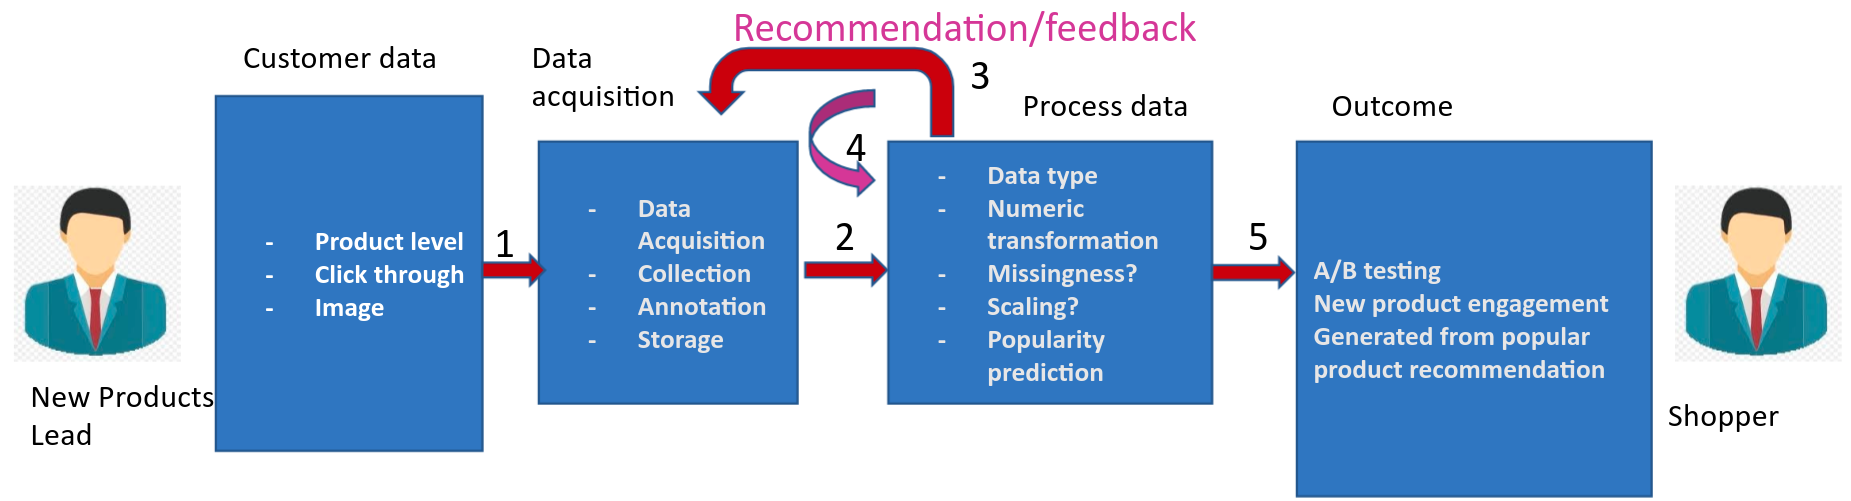

In [40]:
Image(filename='data/design.png')